In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import networkx as nx

In [6]:
cities = {
    "A": (0, 0),
    "B": (1, 5),
    "C": (3, 2),
    "D": (5, 6),
    "E": (7, 1),
    "F": (2, 7),
    "G": (8, 3),
    "H": (4, 9),
    "I": (6, 0),
    "J": (9, 8),
    "K": (1, 2),
    "L": (7, 5),
    "M": (4, 4),
    "N": (0, 8),
    "O": (9, 2)
}

num_cities = len(cities)
city_names = list(cities.keys())
node_names = {i: name for i, name in enumerate(city_names)}

distance_matrix = np.zeros((num_cities, num_cities))
for i in range(num_cities):
    for j in range(num_cities):
        if i == j:
            distance_matrix[i][j] = 0
        else:
            x1, y1 = cities[city_names[i]]
            x2, y2 = cities[city_names[j]]
            distance_matrix[i][j] = np.sqrt((x1 - x2)**2 + (y1 - y2)**2)

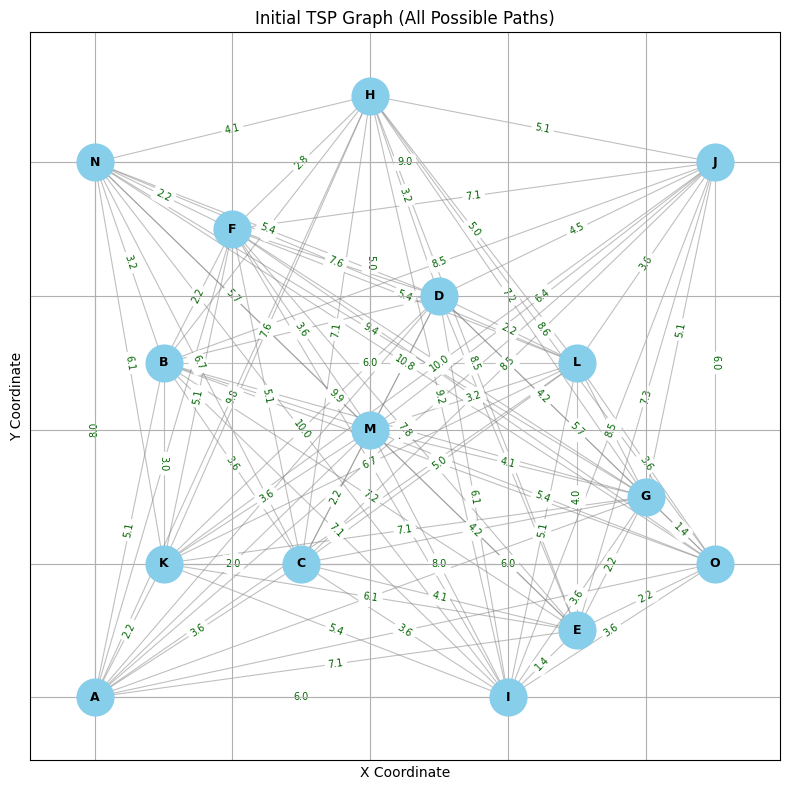

In [7]:
# --- کد برای مصورسازی گراف اولیه ---

plt.figure(figsize=(8, 8)) # ایجاد یک شکل برای نمودار
G = nx.Graph() # ایجاد یک شیء گراف بدون جهت

# اضافه کردن گره‌ها (شهرها) به همراه موقعیت و برچسب
for i, (city_name, coords) in enumerate(cities.items()):
    G.add_node(i, pos=coords, label=city_name) 

# دریافت موقعیت‌های گره‌ها برای رسم
pos = nx.get_node_attributes(G, 'pos')

# اضافه کردن تمام یال‌های ممکن با وزن (فاصله)
for i in range(num_cities):
    for j in range(i + 1, num_cities):
        if distance_matrix[i][j] > 0:
            G.add_edge(i, j, weight=distance_matrix[i][j])

# رسم گره‌ها
nx.draw_networkx_nodes(G, pos, node_color='skyblue', node_size=700)
# رسم لیبل گره‌ها (نام شهرها) - حالا 'node_names' در دسترس است
nx.draw_networkx_labels(G, pos, labels=node_names, font_size=9, font_weight='bold')

# رسم یال‌ها (تمام اتصالات ممکن)
nx.draw_networkx_edges(G, pos, width=0.8, alpha=0.5, edge_color='gray')

# رسم لیبل یال‌ها (فاصله‌ها)
edge_labels = nx.get_edge_attributes(G, 'weight')
rounded_edge_labels = {edge: f"{weight:.1f}" for edge, weight in edge_labels.items()}
nx.draw_networkx_edge_labels(G, pos, edge_labels=rounded_edge_labels, font_color='darkgreen', font_size=7)

# تنظیمات نمودار و نمایش
plt.title('Initial TSP Graph (All Possible Paths)')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.grid(True)
plt.tight_layout()
plt.show()

In [8]:
num_ants = 15                 
num_iterations = 800           
alpha = 0.8                      
beta = 2                       
evaporation_rate = 0.7         
initial_pheromone = 0.05        
Q = 100.0

In [9]:
pheromone_matrix = np.full((num_cities, num_cities), initial_pheromone, dtype=float)
best_overall_tour = None
best_overall_tour_length = float('inf')
history_best_tour_lengths = [] # To plot convergence

In [10]:
def calculate_tour_length(tour, dist_matrix):
    """Calculates the total length of a given TSP tour."""
    length = 0
    for i in range(len(tour) - 1):
        length += dist_matrix[tour[i]][tour[i+1]]
    length += dist_matrix[tour[-1]][tour[0]] # Return to the starting city
    return length

In [11]:
def calculate_transition_probabilities(current_city_idx, visited_cities_indices, pheromone_mat, dist_mat, alpha_param, beta_param):
    """
    Calculates the probabilities for an ant to move to the next unvisited city.
    Returns: (list of possible_next_city_indices, list of normalized_probabilities)
    """
    unvisited_cities = [city_idx for city_idx in range(num_cities) if city_idx not in visited_cities_indices]

    if not unvisited_cities:
        return [], [] # No unvisited cities left

    attractiveness_values = [] # Pheromone * Heuristic (1/distance)
    possible_next_city_indices = []

    for next_city_idx in unvisited_cities:
        pheromone = pheromone_mat[current_city_idx][next_city_idx]**alpha_param
        
        distance = dist_mat[current_city_idx][next_city_idx]
        if distance == 0: # Should not happen between different cities
            heuristic = 0
        else:
            heuristic = (1.0 / distance)**beta_param
        
        attractiveness_values.append(pheromone * heuristic)
        possible_next_city_indices.append(next_city_idx)

    total_attractiveness = sum(attractiveness_values)

    if total_attractiveness == 0:
        # If no valid path (e.g., all pheromones are zero, or stuck),
        # return random choice among valid unvisited cities
        return unvisited_cities, [1.0 / len(unvisited_cities)] * len(unvisited_cities) if unvisited_cities else ([], [])

    normalized_probabilities = [a / total_attractiveness for a in attractiveness_values]
    return possible_next_city_indices, normalized_probabilities

In [12]:
def choose_next_city(possible_next_city_indices, normalized_probabilities):
    """
    Chooses the next city based on the given normalized probabilities.
    """
    if not possible_next_city_indices:
        return None
    
    # Use random.choices for probabilistic selection (roulette wheel)
    chosen_city_idx = random.choices(possible_next_city_indices, weights=normalized_probabilities, k=1)[0]
    return chosen_city_idx

In [13]:
print("Starting Ant Colony Optimization for TSP...")

for iteration in range(num_iterations):
    all_ants_tours = []
    all_ants_tour_lengths = []

    # --- Ant Movement (Tour Construction Phase) ---
    for ant_id in range(num_ants):
        # Each ant starts from a random city to promote exploration
        start_city_for_ant = random.randint(0, num_cities - 1)
        current_tour = [start_city_for_ant]
        visited_cities_by_ant = {start_city_for_ant}

        for _ in range(num_cities - 1):
            current_city = current_tour[-1]
            
            possible_next_cities, probabilities = calculate_transition_probabilities(
                current_city, visited_cities_by_ant, pheromone_matrix, distance_matrix, alpha, beta
            )
            
            next_city = choose_next_city(possible_next_cities, probabilities)
            
            if next_city is None: # Should not happen in a connected TSP graph unless stuck
                current_tour = [] # Mark as invalid tour
                break
            
            current_tour.append(next_city)
            visited_cities_by_ant.add(next_city)
        
        # If the ant successfully visited all cities
        if len(current_tour) == num_cities:
            tour_length = calculate_tour_length(current_tour, distance_matrix)
            all_ants_tours.append(current_tour)
            all_ants_tour_lengths.append(tour_length)

            # Update the overall best tour found so far
            if tour_length < best_overall_tour_length:
                best_overall_tour_length = tour_length
                best_overall_tour = list(current_tour) # Store a copy

    # --- Pheromone Update Phase ---
    
    pheromone_matrix *= (1 - evaporation_rate)

    for i in range(len(all_ants_tours)):
        tour = all_ants_tours[i]
        tour_length = all_ants_tour_lengths[i]
        
        if tour_length > 0: # Avoid division by zero
            pheromone_to_deposit = Q / tour_length
        else:
            pheromone_to_deposit = 0 

        # Deposit pheromone on all edges of the tour (including return to start)
        for j in range(len(tour)):
            city1_idx = tour[j]
            city2_idx = tour[(j + 1) % num_cities] # Handles wrapping around for the last city to first city connection
            
            pheromone_matrix[city1_idx][city2_idx] += pheromone_to_deposit
            pheromone_matrix[city2_idx][city1_idx] += pheromone_to_deposit # Undirected graph

    history_best_tour_lengths.append(best_overall_tour_length)

    if iteration % 50 == 0 or iteration == num_iterations - 1:
        print(f"Iteration {iteration+1}/{num_iterations}: Best tour length found = {best_overall_tour_length:.2f}")

print("\n--- Final Results ---")
print(f"Shortest tour length found: {best_overall_tour_length:.2f}")
if best_overall_tour:
    final_tour_names = [city_names[idx] for idx in best_overall_tour]
    print(f"Best tour found: {' -> '.join(final_tour_names)} -> {final_tour_names[0]}")
else:
    print("No valid tour found.")

Starting Ant Colony Optimization for TSP...
Iteration 1/800: Best tour length found = 53.46
Iteration 51/800: Best tour length found = 42.40
Iteration 101/800: Best tour length found = 42.40
Iteration 151/800: Best tour length found = 42.40
Iteration 201/800: Best tour length found = 42.40
Iteration 251/800: Best tour length found = 42.40
Iteration 301/800: Best tour length found = 42.32
Iteration 351/800: Best tour length found = 42.32
Iteration 401/800: Best tour length found = 42.32
Iteration 451/800: Best tour length found = 42.32
Iteration 501/800: Best tour length found = 42.32
Iteration 551/800: Best tour length found = 42.32
Iteration 601/800: Best tour length found = 42.32
Iteration 651/800: Best tour length found = 42.32
Iteration 701/800: Best tour length found = 42.32
Iteration 751/800: Best tour length found = 42.32
Iteration 800/800: Best tour length found = 42.32

--- Final Results ---
Shortest tour length found: 42.32
Best tour found: I -> E -> O -> G -> L -> J -> D -> 

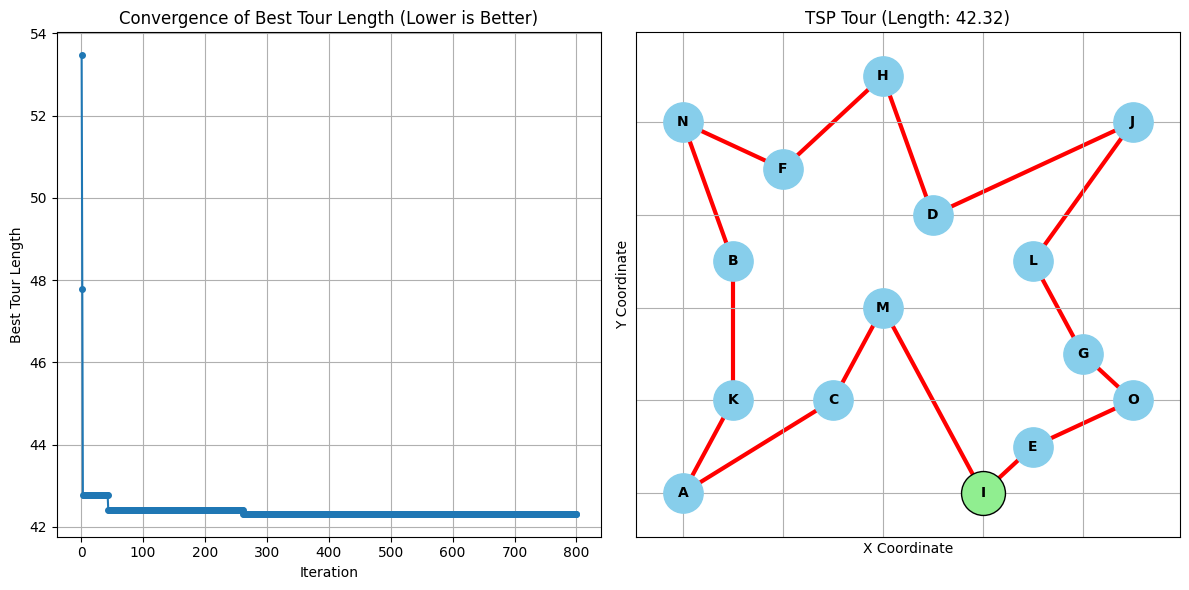

In [14]:
plt.figure(figsize=(12, 6))

# Subplot 1: Convergence Plot
plt.subplot(1, 2, 1)
plt.plot(range(1, len(history_best_tour_lengths) + 1), history_best_tour_lengths, marker='o', markersize=4)
plt.title('Convergence of Best Tour Length (Lower is Better)')
plt.xlabel('Iteration')
plt.ylabel('Best Tour Length')
plt.grid(True)

# Subplot 2: TSP Tour Visualization
plt.subplot(1, 2, 2)
G = nx.Graph()

# Add nodes (cities) with their positions
for i, (city_name, coords) in enumerate(cities.items()):
    G.add_node(i, pos=coords, label=city_name)

# Get positions for drawing
pos = nx.get_node_attributes(G, 'pos')

# Draw nodes
nx.draw_networkx_nodes(G, pos, node_color='skyblue', node_size=800)
# Draw node labels
nx.draw_networkx_labels(G, pos, labels={i: name for i, name in enumerate(city_names)}, font_size=10, font_weight='bold')

# Draw all possible edges faintly (optional, for context)
# You might want to skip this for very dense graphs
# for i in range(num_cities):
#     for j in range(i + 1, num_cities):
#         if distance_matrix[i][j] > 0:
#             G.add_edge(i, j, weight=distance_matrix[i][j])
# nx.draw_networkx_edges(G, pos, width=0.5, alpha=0.3, edge_color='gray')

# Draw the best found TSP tour
if best_overall_tour:
    # Create edges for the best tour, including return to start
    tour_edges = []
    for i in range(len(best_overall_tour)):
        city1_idx = best_overall_tour[i]
        city2_idx = best_overall_tour[(i + 1) % num_cities] # Connects last city to first
        tour_edges.append((city1_idx, city2_idx))
    
    nx.draw_networkx_edges(G, pos, edgelist=tour_edges, edge_color='red', width=3.0, style='solid')

# Highlight start city (first city in the best_overall_tour)
if best_overall_tour:
    nx.draw_networkx_nodes(G, pos, nodelist=[best_overall_tour[0]], node_color='lightgreen', node_size=1000, edgecolors='black', linewidths=1)


plt.title(f'TSP Tour (Length: {best_overall_tour_length:.2f})')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.grid(True)
plt.tight_layout()
plt.show()